# Generative Adversarial Network Example

Build a generative adversarial network (GAN) to generate digit images from a noise distribution with TensorFlow.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [1]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import mxnet as mx

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


# Classifier Model

In [3]:
# Training Parameters
learning_rate_cnn = 0.001
num_steps_cnn = 500
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [4]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)

    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)

    # Apply Dropout
    #fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

In [5]:
# Store layers weight & bias
weights_cnn = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 128])),
    'wd2': tf.Variable(tf.random_normal([128, 64])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([64, num_classes]))
}

biases_cnn = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([128])),
    'bd2': tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights_cnn, biases_cnn, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
loss_sc = -tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_cnn)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Discriminator Model

In [6]:
# Training Parameters
learning_rate_discriminator = 0.001
batch_size_discriminator = 128

# Network Parameters
num_input_discriminator = 784 # MNIST data input (img shape: 28*28)
num_classes_discriminator = 1 # One score for each image
dropout_discriminator = 0.75 # Dropout, probability to keep units

In [7]:
# Create the neural network
def cnn_dis (x, dropout, batch_size, reuse):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('Discriminator', reuse=reuse):
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[batch_size, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu,name='conv1')
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 32 filters and a kernel size of 5
        conv2 = tf.layers.conv2d(conv1, 64, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 128)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.nn.relu(fc1)

        # Add second Fully connected layer
        fc2 = tf.layers.dense(fc1, 128)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc2 = tf.layers.dropout(fc2, rate=dropout, training=True)
        
        # Output layer, class prediction
        out_l = tf.layers.dense(fc2, 1)

#         # Output layer, class prediction
#         out_l = tf.layers.dense(fc1, 1)        
        #Output layer after sigmoid
        out = tf.nn.sigmoid(out_l)  

    return out, out_l

In [8]:
# Store layers weight & bias
weights_cnn_dis = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 128])),
    'wd2': tf.Variable(tf.random_normal([128, 64])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([64, num_classes]))
}

biases_cnn_dis = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([128])),
    'bd2': tf.Variable(tf.random_normal([64])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}



X_fake = tf.placeholder(tf.float32, [None, num_input_discriminator])
X_real = tf.placeholder(tf.float32, [None, num_input_discriminator])
dis_logist_fake = conv_net(X_fake, weights_cnn_dis, biases_cnn_dis, keep_prob)
dis_logist_real = conv_net(X_real, weights_cnn_dis, biases_cnn_dis, keep_prob)

dis_score_real = tf.nn.sigmoid(dis_logist_real)
dis_score_fake = tf.nn.sigmoid(dis_logist_fake)

dis_img = -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logist_fake, labels=tf.ones_like(dis_logist_fake)))
dis_grad = tf.gradients(dis_img, X_fake)


disc_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logist_real, labels=tf.ones_like(dis_logist_real)))
disc_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logist_fake, labels=tf.zeros_like(dis_logist_fake)))
disc_loss = disc_real + disc_fake

# Create Optimizer and training operations 
opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator)
train_dis = opt_real.minimize(disc_loss, global_step=tf.train.get_global_step())


In [9]:
from IPython import display


In [10]:
from IPython import display
# # Real image: discriminator(X) = 1;  Fake image: discriminator(X) = 0;
# X_fake = tf.placeholder(tf.float32, [None, num_input_discriminator])
# X_real = tf.placeholder(tf.float32, [None, num_input_discriminator])
# dis_score_fake,dis_logist_fake = cnn_dis(X_fake, dropout_discriminator, batch_size_discriminator, reuse = False)
# dis_score_real,dis_logist_real = cnn_dis(X_real, dropout_discriminator, batch_size_discriminator, reuse = True)

# dis_img = tf.reduce_mean(tf.log(dis_score_fake))
# dis_grad = tf.gradients(dis_img, X_fake)

# disc_real = -tf.reduce_mean(tf.log(dis_score_real))
# disc_fake = -tf.reduce_mean(tf.log(1. - dis_score_fake))
# disc_loss = disc_real + disc_fake

# # Create Optimizer and training operations 
# opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate_discriminator)
# train_dis = opt_real.minimize(disc_loss, global_step=tf.train.get_global_step())

### Target classifier output layer gradient to look at

In [11]:
zero = tf.slice(logits,begin=[0,0],size=[128,1])
#grad = tf.gradients(tf.reduce_mean(zero), X)
grad = tf.gradients(loss_sc, X)

# Training

In [12]:
# Training the classifier
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.133)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#with tf.Session() as sess:
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [13]:
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.133)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())

In [16]:
# Training the classifier
#with tf.Session() as sess:

# Run the initializer
#sess.run(tf.global_variables_initializer())
# Add ops to save and restore all the variables.
saver = tf.train.Saver()
for step in range(1, num_steps_cnn+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                             Y: batch_y,
                                                             keep_prob: 1.0})
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))
# save_path = saver.save(sess, "./modles/MNSTClassodel.ckpt")
print("Optimization Finished!")

# Calculate accuracy for 256 MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                  Y: mnist.test.labels[:256],
                                  keep_prob: 1.0}))

Step 1, Minibatch Loss= 932.2800, Training Accuracy= 0.898
Step 10, Minibatch Loss= 1103.6030, Training Accuracy= 0.953
Step 20, Minibatch Loss= 625.6923, Training Accuracy= 0.930
Step 30, Minibatch Loss= 839.5539, Training Accuracy= 0.953
Step 40, Minibatch Loss= 761.4567, Training Accuracy= 0.914
Step 50, Minibatch Loss= 499.9922, Training Accuracy= 0.945
Step 60, Minibatch Loss= 727.4823, Training Accuracy= 0.969
Step 70, Minibatch Loss= 1422.9919, Training Accuracy= 0.914
Step 80, Minibatch Loss= 625.7014, Training Accuracy= 0.945
Step 90, Minibatch Loss= 500.8728, Training Accuracy= 0.961
Step 100, Minibatch Loss= 819.0713, Training Accuracy= 0.914
Step 110, Minibatch Loss= 1008.6431, Training Accuracy= 0.938
Step 120, Minibatch Loss= 563.0700, Training Accuracy= 0.945
Step 130, Minibatch Loss= 866.1906, Training Accuracy= 0.930
Step 140, Minibatch Loss= 1129.3710, Training Accuracy= 0.922
Step 150, Minibatch Loss= 331.2089, Training Accuracy= 0.953
Step 160, Minibatch Loss= 1348.

In [15]:
# save_path = saver.save(sess, "./models/class_fc2_discriminator.ckpt")
#saver.restore(sess, "./models/class_fc2_discriminator.ckpt")
# #weights_now = sess.run(weights_cnn['wc1'])
# #print(weights_now)
# def resetit():
#     sess.run(tf.global_variables_initializer())
#     saver.restore(sess, "./models/class_and_fc2_discriminator_.ckpt")
    

In [17]:
gpu_device=mx.gpu()
n = 10
canvas = np.empty((28 * n, 28 * n))

In [18]:
my_Y = np.zeros((128,10))
for i in range(128):
    my_Y[i][7]= 1
#print(my_Y)
from ipywidgets import widgets
from ipywidgets import IntSlider
from ipywidgets import FloatSlider
from ipywidgets import Checkbox
from ipywidgets import ToggleButton

In [19]:
learning_rate_class = 0.05
learning_rate_dis = 0.01
style = {'description_width': 'initial'}

In [94]:
accumulateClassifier[:]=0

In [20]:
#accumulateDiscriminator = mx.nd.zeros((batch_size_discriminator, num_input_discriminator),gpu_device)
#accumulateClassifier = mx.nd.zeros((batch_size_discriminator, num_input_discriminator),gpu_device)
noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
img = noise_img
g, ll, p, dis_score, dl_, g_from_dis,di = sess.run(
                    [grad, loss_op, prediction, dis_img, dis_logist_fake, dis_grad,dis_img], \
                    feed_dict={X: img , Y: my_Y , X_fake: img , keep_prob: 1.0})
g_cls = mx.nd.array(g[0],gpu_device)
g_dis = mx.nd.array(g_from_dis[0],gpu_device)
accumulateClassifier = 0.2 * g_cls ** 2 + 0.8 * accumulateClassifier
accumulateDiscriminator = 0.1 * g_dis ** 2 + 0.9 * accumulateDiscriminator
normalized_class_grad = g_cls / mx.nd.sqrt(accumulateClassifier + 1e-8)
normalized_dis_grad = g_dis / mx.nd.sqrt(accumulateDiscriminator)
# Add the gradient from discriminator and classifier
img += ((learning_rate_class) * normalized_class_grad).asnumpy()#(normalized_class_grad+float(grad_noise_slider.value)/10*mx.nd.random.normal(1/((i+1)*0.55)))
img += ((learning_rate_dis) * (normalized_dis_grad)).asnumpy()

batch_x, _ = mnist.train.next_batch(batch_size_discriminator)
a=sess.run([train_dis,disc_loss], feed_dict={X_fake: img , X_real: batch_x})
g_cls,accumulateClassifier,normalized_class_grad

NameError: name 'accumulateClassifier' is not defined

In [51]:
g, ll, p, dis_score, dl_, g_from_dis,di = sess.run(
                    [grad, loss_op, prediction, dis_img, dis_logist_fake, dis_grad,dis_img], \
                    feed_dict={X: img , Y: my_Y , X_fake: img , keep_prob: 1.0})

dl_

array([[-685194.1875],
       [-740018.5   ],
       [-712261.0625],
       [-712705.875 ],
       [-709147.875 ],
       [-729449.4375],
       [-731944.625 ],
       [-716271.    ],
       [-713660.25  ],
       [-721816.6875],
       [-689772.5   ],
       [-739706.875 ],
       [-700450.9375],
       [-719635.3125],
       [-713812.5   ],
       [-649033.25  ],
       [-687006.125 ],
       [-710431.0625],
       [-729294.3125],
       [-691525.    ],
       [-730165.    ],
       [-696231.9375],
       [-711687.0625],
       [-718284.625 ],
       [-700695.6875],
       [-659760.5625],
       [-706476.1875],
       [-707110.375 ],
       [-749799.5625],
       [-727954.375 ],
       [-728992.3125],
       [-733114.1875],
       [-725850.9375],
       [-692778.875 ],
       [-714012.75  ],
       [-719920.3125],
       [-719969.9375],
       [-688918.5   ],
       [-722844.    ],
       [-703235.5625],
       [-716008.0625],
       [-693666.0625],
       [-744958.1875],
       [-71

In [81]:
a=mx.nd.sqrt(accumulateDiscriminator+1e-8)
g_dis[0][0],a[0][0]
g_dis[0][0]/mx.nd.sqrt(accumulateDiscriminator[0][0])
normalized_dis_grad
b = g_dis **2
g_dis[0][0],mx.nd.sqrt(accumulateDiscriminator)[0][0]
0.1 * (g_dis ** 2) + 0.9 * accumulateDiscriminator


[[  4.75034714e+00   1.02472298e+02   2.40913916e+00 ...,   6.66282806e+01
    3.90548706e+01   4.29144325e+01]
 [  1.74761581e+01   7.31394348e+01   9.19455490e+01 ...,   1.27819046e+02
    2.81409836e+01   1.00310926e+01]
 [  5.88583529e-01   1.97220249e+01   1.97178669e+01 ...,   9.48859406e+00
    3.77764177e+00   3.36206665e+01]
 ..., 
 [  1.51853889e-01   1.66253090e+01   4.19931259e+01 ...,   4.62556458e+01
    1.96540117e-04   1.40595961e+01]
 [  2.27721520e-02   2.70009277e+02   6.90191895e+02 ...,   1.28321350e+02
    9.98440552e+00   1.39275112e+01]
 [  7.01411605e-01   6.04386568e-01   1.71429157e-01 ...,   1.53370583e+00
    7.25107422e+01   6.66155434e+00]]
<NDArray 128x784 @gpu(0)>

ll:496.224
 time: 0.00651420593262


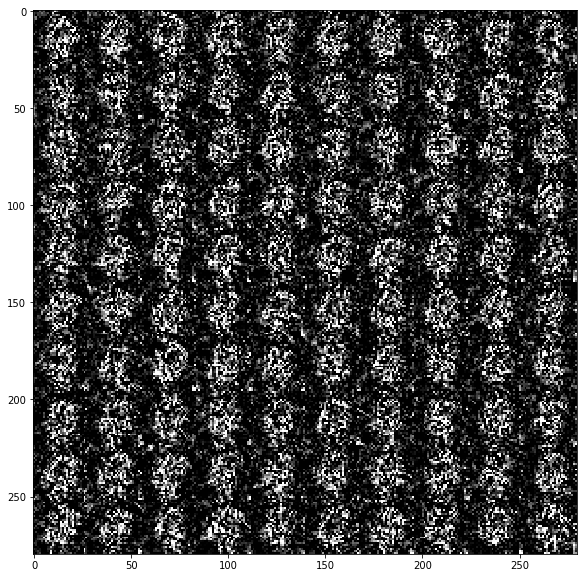

iter=0
Picture No.7
Discriminator has been trained 70 times
100 steps of gd: 0.728731155396


FloatSlider(value=0.0, description=u'Gradient Noise Level', style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.172, description=u'LR of Cls Grad', max=0.5, step=0.001, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.186, description=u'LR of Dis Grad', max=0.5, step=0.001, style=SliderStyle(description_width=u'initial'))

IntSlider(value=4, description=u'Iter count', min=1, style=SliderStyle(description_width=u'initial'))

Checkbox(value=False, description=u'Stop Training Discriminator')

ToggleButton(value=False, button_style=u'danger', description=u'Stop', icon=u'check', tooltip=u'Stop')

Discriminator Score=-13311.2 -88320.3 -12644.2 After 29 steps
Still training discriminator
IO time: 0.271656990051
train 1 step: 0.0274209976196


In [24]:
from math import sqrt
import threading
import time
grad_noise_slider = FloatSlider(description='Gradient Noise Level', style=style)
lr_cls_slider = FloatSlider(description = 'LR of Cls Grad', style=style,min=0,max=0.5,step=0.001,value=0.01)
lr_dis_slider = FloatSlider(description = 'LR of Dis Grad',min=0,max=0.5,step=0.001,style=style,value=0.01)
iter_slider = IntSlider(description = 'Iter count',min=1,max=100,step=1,style=style,value=4)
stop_training_dis_check = Checkbox(description = 'Stop Training Discriminator', value=False)
stop_button = ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger',
    tooltip='Stop',
    icon='check'
)
def work():
    # Train Discriminator
    accumulateDiscriminator = mx.nd.zeros((batch_size_discriminator, num_input_discriminator),gpu_device)
    accumulateClassifier = mx.nd.zeros((batch_size_discriminator, num_input_discriminator),gpu_device)
    momentum = mx.nd.zeros((batch_size_discriminator, num_input_discriminator),gpu_device)
    train_no = 0
    noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
    img = noise_img
    for j1 in range(200):
        noise_img = np.random.rand(batch_size_discriminator, num_input_discriminator)
        img = noise_img
        accumulateDiscriminator[:] = 0
        accumulateClassifier[:] = 0
        momentum[:] = 0
        for k in range(10):
            st, end = 0, 0
            learning_rate_class = lr_cls_slider.value
            learning_rate_dis = lr_dis_slider.value      
            stop_training_dis = stop_training_dis_check.value
            if(stop_button.value): return
            time1 = time.time()
            time5=0.0
            time6=0.0
            for i in range(30):
                # What's the input batch_y should be?
                time5+= time.time()
                g, ll, p, dis_score, dl_, g_from_dis = sess.run(
                    [grad, loss_op, prediction, dis_img, dis_logist_fake, dis_grad], \
                    feed_dict={X: img , Y: my_Y , X_fake: img , keep_prob: 1.0})
                time6+= time.time()
                # Accumulate and Normalize the gradient
                g_cls = mx.nd.array(g[0],gpu_device)
                g_dis = mx.nd.array(g_from_dis[0],gpu_device)
                accumulateClassifier = 0.1 * g_cls ** 2 + 0.9 * accumulateClassifier
                accumulateDiscriminator = 0.1 * g_dis ** 2 + 0.9 * accumulateDiscriminator
                normalized_class_grad = g_cls / mx.nd.sqrt(accumulateClassifier + 1e-8)
                normalized_dis_grad = g_dis / mx.nd.sqrt(accumulateDiscriminator+1e-8)
                # Add the gradient from discriminator and classifier
                gg = (learning_rate_class) * normalized_class_grad + (learning_rate_dis) * (normalized_dis_grad)
                momentum = 0.1*gg + 0.9*momentum
                img += momentum.asnumpy()
                #img += ((learning_rate_class) * normalized_class_grad).asnumpy()#(normalized_class_grad+float(grad_noise_slider.value)/10*mx.nd.random.normal(1/((i+1)*0.55)))
                #img += ((learning_rate_dis) * (normalized_dis_grad)).asnumpy()
                #time7 +=time.time()
                # Clipping the image to range 0-1
                img[img > 1] = 1
                img[img < 0] = 0
                if (i == 0):
                    st = dl_.mean()
                if (dis_score > 0.9):
                    break
            print("ll:"+str(ll))
            runSteps = i
            print(" time: "+str((time6-time5)/100.0))
            time2 = time.time()
            for i in range(n):
                for j in range(n):
                    # Draw the generated digits
                    canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img[(i - 1) * n + j].reshape([28, 28])
            plt.figure(figsize=(n, n))
            plt.imshow(canvas, origin="upper", cmap="gray")
            plt.show()
            print('iter=' + str(k))
            print('Picture No.'+str(j1))
            print('Discriminator has been trained '+str(train_no)+' times')
            print('100 steps of gd: '+str(time2-time1))
            #print("Gradient Noise Level = "+str(float(grad_noise_slider.value)))
            #print("Learning Rate of Classifier Gradient = "+str(lr_cls_slider.value))
            #print("Learning Rate of Discriminator Gradient = "+str(lr_dis_slider.value))
            display.display(grad_noise_slider)
            display.display(lr_cls_slider)
            display.display(lr_dis_slider)
            display.display(iter_slider)
            display.display(stop_training_dis_check)
            display.display(stop_button)
            #display.display(reset_check)
            # print('Dis Gradient range  =' + str(np.min(normalized_dis_grad[0])) + " " + str(np.max(normalized_dis_grad[0])))
            # print('Class Gradient range  =' + str(np.min(normalized_class_grad)) + " " + str(np.max(normalized_class_grad)))
            print('Discriminator Score=' + str(dis_score) + " "+ str(st)+" "+str(dl_.mean())+ " After " + str(runSteps)+ " steps")
            time3 =time.time()
            batch_x, _ = mnist.train.next_batch(batch_size_discriminator)
            if (not stop_training_dis) and (train_no<4000) and (k<10):
                print("Still training discriminator")
                train_no+=1
                sess.run([train_dis], feed_dict={X_fake: img , X_real: batch_x})
            time4 = time.time()
            print('IO time: '+ str(time3-time2))
            print ('train 1 step: '+str(time4-time3))
            display.clear_output(wait=True)
            time.sleep(0.1)
thread = threading.Thread(target=work)
thread.start()
#work()


In [104]:
normalized_dis_grad


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 128x784 @gpu(0)>

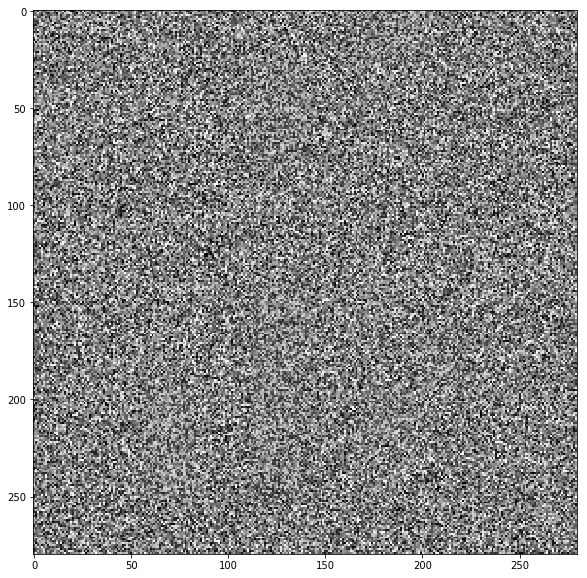

In [22]:
for i in range(n):
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img[(i - 1) * n + j].reshape([28, 28])
plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

In [24]:
g_from_dis

[array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)]

In [26]:
normalized_class_grad


[[ 3.16227746  3.16227746 -3.1622777  ...,  3.1622777   3.16227746
  -3.1622777 ]
 [-3.16227436 -3.1622777   3.16227746 ...,  3.1622777  -3.1622777
   3.16227746]
 [-3.1622777  -3.16227746 -3.1622777  ..., -3.1622777  -3.16227794
   3.1622777 ]
 ..., 
 [ 3.1622777  -3.16227746 -3.1622777  ..., -3.16227746 -3.1622777
  -3.1622777 ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 3.16227746 -3.16227746 -3.16227794 ..., -3.1622777  -3.1622777
   3.16227746]]
<NDArray 128x784 @gpu(0)>

In [25]:
normalized_dis_grad


[[ 3.16227746  3.1622777   3.16227746 ...,  3.1622777  -3.1622777
  -3.1622777 ]
 [-3.1622777   3.16227746 -3.1622777  ...,  3.16227794 -3.1622777
  -3.1622777 ]
 [-3.1622777  -3.16227746 -3.1622777  ...,  3.16227794 -3.1622777
  -3.1622777 ]
 ..., 
 [ 3.16227746 -3.1622777  -3.1622777  ..., -3.16227746  3.1622777
  -3.1622777 ]
 [-3.16227746 -3.1622777   3.1622777  ..., -3.1622777   3.16227746
   3.1622777 ]
 [-3.16227746  3.16227746  3.1622777  ..., -3.1622777  -3.1622777
  -3.16227746]]
<NDArray 128x784 @gpu(0)>

In [23]:
g_dis.asnumpy().min()

nan

In [24]:
sfm=tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y)
ggg=tf.gradients(loss_op,X)
a=sess.run([accuracy,ggg], feed_dict={X: mnist.test.images[:256],
                                  Y: mnist.test.labels[:256],
                                  keep_prob: 1.0})

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [?,784]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: Discriminator/Sigmoid/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_302_Discriminator/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_3', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-e252c0619f47>", line 3, in <module>
    X_fake = tf.placeholder(tf.float32, [None, num_input_discriminator])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_3' with dtype float and shape [?,784]
	 [[Node: Placeholder_3 = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: Discriminator/Sigmoid/_49 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_302_Discriminator/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [69]:
a[1][0].min()

-89.90802

In [39]:
np.log(dl_).mean()

-1.3658472

NameError: name 'dl' is not defined

In [86]:
ll

52550.027

In [45]:
mnist.test.labels[:256]

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [85]:
normalized_dis_grad


[[ -2.14396596e+00  -2.77960968e+00  -3.07054400e+00 ...,   1.88726771e+00
   -1.75057709e+00  -2.02207065e+00]
 [  4.53080118e-01   1.07760203e+00  -1.35472000e+00 ...,   2.27526760e+00
   -1.35257161e+00   1.85299134e+00]
 [  6.29395723e-01   1.74822223e+00  -1.16953999e-01 ...,  -1.25522077e+00
    2.07509327e+00  -2.94111490e+00]
 ..., 
 [  6.09938025e-01  -2.63734913e+00  -1.68347466e+00 ...,  -7.01168925e-02
    7.43530616e-02   2.75090528e+00]
 [  1.75232363e+00   1.74663171e-01   1.44471383e+00 ...,  -7.71331072e-01
    6.26831234e-01   2.19422030e+00]
 [  1.54383814e+00   1.52145640e-03   1.63053226e+00 ...,  -1.93483114e+00
   -2.75894284e+00   2.50712657e+00]]
<NDArray 128x784 @gpu(0)>

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in less


ll:1337.02
 time: 0.0161254882812


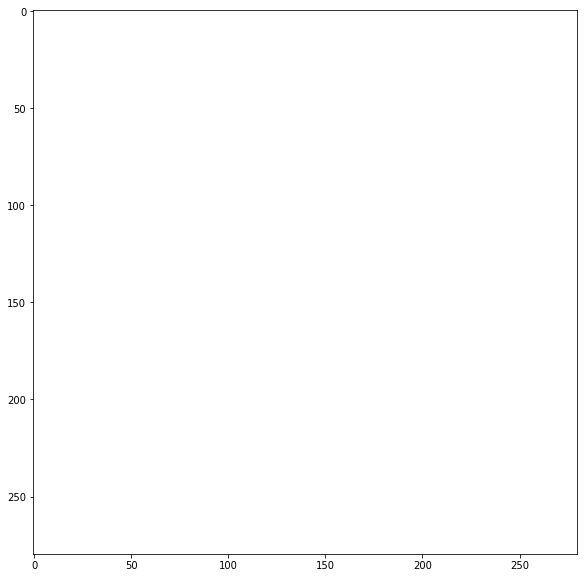

iter=3
Picture No.7
Discriminator has been trained 31 times
100 steps of gd: 1.79981708527


FloatSlider(value=0.0, description=u'Gradient Noise Level', style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.01, description=u'LR of Cls Grad', max=0.5, step=0.001, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.01, description=u'LR of Dis Grad', max=0.5, step=0.001, style=SliderStyle(description_width=u'initial'))

IntSlider(value=4, description=u'Iter count', min=1, style=SliderStyle(description_width=u'initial'))

Checkbox(value=False, description=u'Stop Training Discriminator')

ToggleButton(value=True, button_style=u'danger', description=u'Stop', icon=u'check', tooltip=u'Stop')

Discriminator Score=-0.70719 -0.0295059 -0.0272374 After 99 steps
Still training discriminator
IO time: 0.247581005096
train 1 step: 0.0194759368896


In [90]:
biases_cnn["bn1"]

In [92]:
sess.run(biases_cnn["bc1"])

array([ 0.85255617, -1.64773607,  1.59707844,  0.37759992, -0.0705649 ,
        0.99594873,  0.49222022,  0.17030965, -0.80397207, -0.58236492,
       -0.9522329 , -1.4574759 , -0.38886636,  1.01578951, -0.5669468 ,
        0.61155081, -0.0574533 ,  0.25994343, -0.99087912, -0.25110632,
        0.8387965 ,  0.2165481 ,  1.12133169, -1.79974759, -0.41144145,
       -0.03472836, -0.50206351, -1.22634387, -0.22178872,  0.31589192,
       -0.26306486,  0.91849196], dtype=float32)

In [33]:
sess.run(weights_cnn["wc1"])

array([[[[ -9.16085482e-01,  -9.62725580e-01,  -1.29847205e+00,
            5.13244629e-01,   5.14055192e-01,   5.38154483e-01,
           -7.21371293e-01,   5.68431914e-02,   3.11144352e-01,
            4.52920683e-02,   1.95534098e+00,  -6.63687944e-01,
            1.20313239e+00,  -9.41838205e-01,  -3.50122392e-01,
           -2.24958205e+00,  -7.68824577e-01,  -2.77146012e-01,
           -3.96492407e-02,  -2.58381397e-01,   3.84540021e-01,
            1.64764032e-01,   8.72313917e-01,  -5.04129648e-01,
           -1.23631549e+00,  -3.78740358e+00,   7.63841987e-01,
            4.75581795e-01,  -9.77930963e-01,  -8.87060761e-01,
           -2.82659262e-01,   1.99807752e-02]],

        [[ -4.51896399e-01,  -2.01219535e+00,   2.17620894e-01,
            6.06797576e-01,   1.41134953e+00,  -1.21746755e+00,
           -1.79424390e-01,   1.31032312e+00,  -4.15610313e-01,
            1.02659678e+00,   8.80127966e-01,   7.06455231e-01,
           -3.11086059e-01,  -5.70513070e-01,  -1.97267